In [2]:
from fastai.vision.all import *
import pandas as pd
from fastai.data.all import *
from pathlib import Path

# Introdusjon

Denne oppgaven går ut på å utforske bruken av maskinlæring i patologi. Patologer jobber med å se etter sykdommer ved hjelp av vevprøver. Dette kan være et repetitivt yrke. Og på grunn av en nedgang i antall patologer, vil verktøy som kunstig intelligens og andre algoritmer være nyttig. Vi skal i denne oppgaven trene litt forkjellige modeller og se hvor grensene går i forhold til hva vi kan forutsi ved hjelp av bilder.

# Første modell
### "Histopathologic cancer detection"

Målet med den første modellen vi lager er å se etter kreft i små deler av WSI bilder. WSI står for "Whole Slide Images" og er små snitt av vevprøver som er farget og undersøkt i mikroskop. Bildene vi har og bruker er veldig små deler av disse bildene som ellers kan være over 1GB i størrelse.

In [3]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')  # e.g., 'labels.csv'

#For testing lager vi en variabel som inneholder kun 10% av datasettet.
subset_df = df.sample(frac=0.1)

Kan ikke bruke lambda utrykk i datablock-en når denne skal eksporteres, derfor definerer vi de på forhånd.

In [5]:
def get_x(r): return "/kaggle/input/histopathologic-cancer-detection/train/" + f"{r['id']}.tif"
def get_y(r): return r['label']

#GAMMEL DATABLOCK, INNEHOLDER LAMBDA
#data_block = DataBlock(
#    blocks=(ImageBlock, CategoryBlock),
#    get_x=lambda r: f"/kaggle/input/histopathologic-cancer-detection/train/{r['id']}.tif",
#    get_y=lambda r: r['label'],
#    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% data as validation set
#    item_tfms=Resize(224), # Resize images to 224x224
#    batch_tfms=aug_transforms() # Basic data augmentation
#)

data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
)

Her foregår trening av selve modellen, og når vi trener, ser vi at vi får en nøyaktighet på 97.7%.

In [6]:
dataloaders = data_block.dataloaders(df)

learn = vision_learner(dataloaders, resnet34, metrics=accuracy)

learn.fine_tune(6)  # Train for 6 epochs

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.256364,0.212214,0.916737,12:13


epoch,train_loss,valid_loss,accuracy,time
0,0.170512,0.134944,0.952210,10:41
1,0.144975,0.143431,0.946392,10:38
2,0.117239,0.096963,0.966186,10:26
3,0.080445,0.085610,0.970662,10:10
4,0.074018,0.069820,0.976957,10:05
5,0.046909,0.069476,0.976684,10:40


Når man ser på konkurransen datasettet kommer fra kan man se at de aller fleste får en nøyaktighet på 97.99%. Derfor vil jeg si at vår nøyaktighet er som forventet i forhold til de aller fleste. Akkurat dette er et veldig godt datasett å jobbe med, og et bra eksempel på hva maskinlæring kan brukes til

## Confusion matrix

Her skriver vi ut en matrise som viser tydlig hvor mange av prediksjonene som er riktig.

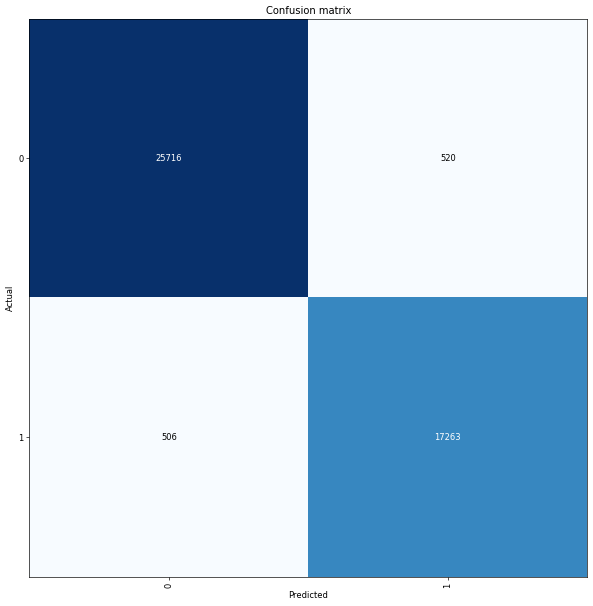

In [7]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

## Plot

vi skriver også ut noen av bildene som har blitt klassifisert feil, selv om dette ikke sier oss så mye. vil dette likevel gi noen med mer faglig kopetanse muligheten til å undersøke hva som går galt

In [ ]:

#interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,10))

For å eksportere modellen når den er ferdig trent bruker vi pickle. Dette er for å teste diverse webapplikasjoner. 

In [11]:
import dill as pickle

In [12]:
learn.export('/kaggle/working/histopathologic_cancer_detection.pkl')

## Evaluering

Siden nøyaktigheten til denne modellen virker å være veldig bra ville vi legge den inn i konkurransen datasettet kommer fra, for å sammenlikne oss med andres resultat.

In [14]:
'''
from fastai.vision.all import PILImage

def predict_image(image_path, model):
    img = PILImage.create(image_path)
    pred,_,probs = model.predict(img) 
    return pred, probs

_=0
'''

In [ ]:
'''
# Henter ut test settet fra mappen
image_folder = Path('/kaggle/input/histopathologic-cancer-detection/test')
image_paths = list(image_folder.glob('*.tif'))

# Lager to lister, en for prediksjoner og en for id'ene til bildene
predictions = []
image_ids = []

#kjører deretter en Loop for å legge disse inn i 
for image_path in image_paths:
    pred = predict_image(image_path, learn)
    predictions.append(pred)
    image_ids.append(image_path.stem) # .stem gir filnavnet uten filtype
    
_=0
'''

In [ ]:
'''
# Lage en dataframe
results_df = pd.DataFrame({
    'id': image_ids,
    'label': predictions
})

# lagre som CSV
results_df.to_csv('predictions.csv', index=False)
'''

## Trening av det andre datasettet med en seperat modell
For å finne ut hvor mange måneder en person kommer til å leve basert på vevsprøver. 

### Dette fungerer ikke!
Årsaken til at dette ikke virker er nok grunnet flere årsaker. Både er dette tall som sikkert ikke har veldig mye tilknytning til bildene vi bruker, ettersom at dødsårsak ikke er oppgitt. I tillegg er det nok flere som ikke har dødd innen tiden dette eksperimentet tok sted.


### Forkjellige modeller
Har har vi også testet med en del ulike modeller for å se om dette utgjorde noen forkjell, men resultatet ble like dårlig.

In [18]:

df2 = pd.read_csv('/kaggle/input/survival-months/pathfusion/tmidata_100rnaseq_cv_splits.csv') 


def get_x2(r): return "/kaggle/input/survival-months/PNAS-images/" + f"{r['imgs']}"
def get_y2(r): return r['Survival months']


data_block2 = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=get_x2,
    get_y=get_y2,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
)

dataloaders2 = data_block2.dataloaders(df2)

learn2 = vision_learner(dataloaders2, vgg16, metrics=rmse)

learn2.fine_tune(4)  # Train for 4 epochs


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s]  


epoch,train_loss,valid_loss,_rmse,time
0,1606893.875000,1243175.375000,1114.977783,00:44


epoch,train_loss,valid_loss,_rmse,time
0,1564731.875000,1243789.000000,1115.252930,00:37
1,1551867.125000,1245796.250000,1116.152466,00:37
2,1572982.375000,1245649.375000,1116.086670,00:37
3,1582375.625000,1244354.250000,1115.506348,00:37


Text(0.5, 1.0, 'Predictions vs Targets')

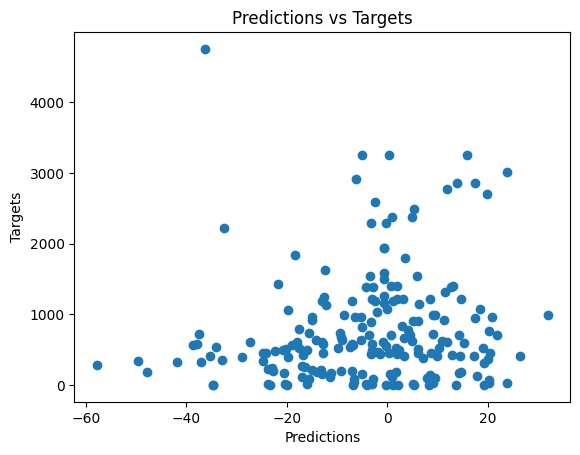

In [19]:
preds, targs = learn2.get_preds()

plt.scatter(preds.numpy(), targs.numpy())
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.title('Predictions vs Targets')

## Bruker samme datasett, men nå trener vi den på hvilken molekylær subtype dette er
fungerer bedre, men er ikke veldig nøyaktig. Dette kan være grunnet lite data. Eller så er dette også en verdi som ikke blir representert i bildene, og at den derfor ender opp med å gjette litt.

In [20]:

df3 = pd.read_csv('/kaggle/input/survival-months/pathfusion/tmidata_100rnaseq_cv_splits.csv')


def get_x3(r): return "/kaggle/input/survival-months/PNAS-images/" + f"{r['imgs']}"
def get_y3(r): return r['Molecular subtype']


data_block3 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x3,
    get_y=get_y3,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
)


dataloaders3 = data_block3.dataloaders(df3)

learn3 = vision_learner(dataloaders3, resnet50, metrics=accuracy)

learn3.fine_tune(7)  

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,1.713713,1.043088,0.537688,00:37


epoch,train_loss,valid_loss,accuracy,time
0,1.457253,1.364252,0.497487,00:37
1,1.386461,1.433060,0.477387,00:37
2,1.344980,1.307765,0.603015,00:37
3,1.264412,1.205293,0.608040,00:37
4,1.207542,1.293260,0.582915,00:37
5,1.115511,1.320229,0.587940,00:38
6,1.051603,1.280224,0.597990,00:32


## Confusion Matrix
som man ser på matrisen under tar modellen mer rett enn feil. Men dette er såpass dårlig resultat at det er på grensen til gjetting. Dette er ikke en vellykket test

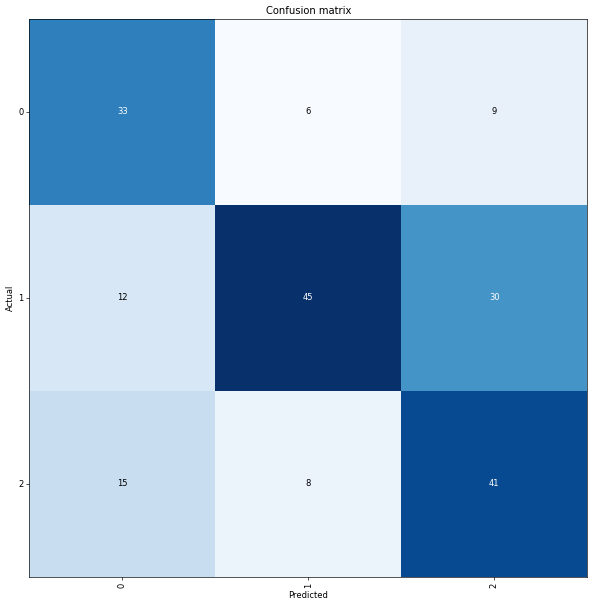

In [21]:
interp2 = ClassificationInterpretation.from_learner(learn3)

interp2.plot_confusion_matrix(figsize=(10,10), dpi=60)

Prøver å trene igjen på histomolecular subtype isteden for på molecular subtype. Disse ser ut til å være med spessifiserte, så er dermed interessant å se hvordan dette påvirker resultatet.

In [3]:
df4 = pd.read_csv('/kaggle/input/survival-months/pathfusion/tmidata_100rnaseq_cv_splits_img.csv') 


def get_x4(r): return "/kaggle/input/survival-months/PNAS-images/" + f"{r['imgs']}"
def get_y4(r): return r['Histomolecular subtype']


data_block4 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x4,
    get_y=get_y4,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
)


dataloaders4 = data_block4.dataloaders(df4)

learn4 = vision_learner(dataloaders4, resnet50, metrics=accuracy)

learn4.fine_tune(7)  

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,2.277869,1.575942,0.361809,00:42


epoch,train_loss,valid_loss,accuracy,time
0,1.917734,1.717416,0.407035,00:36
1,1.814780,2.277659,0.427136,00:37
2,1.749063,2.139090,0.396985,00:36
3,1.670355,1.625646,0.442211,00:36
4,1.584055,1.490976,0.462312,00:36
5,1.490429,1.370334,0.517588,00:37
6,1.439665,1.344359,0.512563,00:36


## Confusion matrix
Som man ser under ble resultatet nå enda værre. Kanskje fordi vi har lite data å trene med, men mest sannsynlig fordi dette er ikke noe som går an å se utifra bildet og det ender bare opp med at modellen gjetter

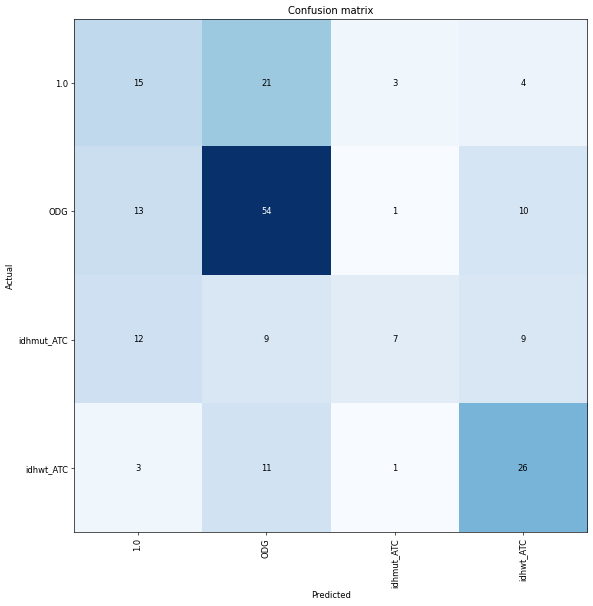

In [4]:
interp3 = ClassificationInterpretation.from_learner(learn4)

interp3.plot_confusion_matrix(figsize=(10,10), dpi=60)

# Konklusjon

Enkelte oppgaver innenfor patologi kan ha stor nytte av Maskinlæring. Som vi ser er den første testen veldig vellykket og en nøyaktighet på 97% kan være bra nok til å få fart på jobben til patologer. Men i denne oppgaven har vi vært ganske urettferdige mot modellene og gitt oppgaver som tydelig har vært for vanskelige, dette kunne nok blitt forbedret ved å fjerne en del data fra treningsdataen, eller lagt på mer informasjon for at modellen skulle ha mer hjelp til å sikte seg inn til riktig svar. Men vi ville teste hvor lett det var å trene modeller på en del forkjellige typer data. Dette viser seg å være veldig lett i noen tilfeller, men i andre krever dette mer jobb.